## POS Tagging, HMMs, Viterbi

Let's learn how to do POS tagging by Viterbi Heuristic using tagged Treebank corpus. Before going through the code, let's first understand the pseudo-code for the same. 

1. Tagged Treebank corpus is available (Sample data to training and test data set)
   - Basic text and structure exploration
2. Creating HMM model on the tagged data set.
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)
3. Developing algorithm for Viterbi Heuristic
4. Checking accuracy on the test data set


## 1. Exploring Treebank Tagged Corpus

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents())

In [3]:
# first few tagged sentences
print(wsj[:40])

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], [('Rudolph', 'NNP'), ('Agnew', 'NNP'), (',', ','), ('55', 'CD'), ('years', 'NNS'), ('old', 'JJ'), ('and', 'CC'), ('former', 'JJ'), ('chairman', 'NN'), ('of', 'IN'), ('Consolidated', 'NNP'), ('Gold', 'NNP'), ('Fields', 'NNP'), ('PLC', 'NNP'), (',', ','), ('was', 'VBD'), ('named', 'VBN'), ('*-1', '-NONE-'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('of', 'IN'), ('this', 'DT'), ('British', 'JJ'), ('industrial', 'JJ'), ('conglomerate', 'NN'), ('.', '.')], [('A', 'DT'), ('f

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

2739
1175
[[('By', 'IN'), ('Tuesday', 'NNP'), ('night', 'NN'), (',', ','), ('television', 'NN'), ('stations', 'NNS'), ('were', 'VBD'), ('carrying', 'VBG'), ('new', 'JJ'), ('ads', 'NNS'), ('featuring', 'VBG'), ('Mr.', 'NNP'), ('Coleman', 'NNP'), ('himself', 'PRP'), ('raising', 'VBG'), ('questions', 'NNS'), ('about', 'IN'), ('Mr.', 'NNP'), ('Wilder', 'NNP'), ("'s", 'POS'), ('sensitivity', 'NN'), ('to', 'TO'), ('rape', 'NN'), ('victims', 'NNS'), ('.', '.')], [('Sales', 'NNS'), ('totaled', 'VBD'), ('1.916', 'CD'), ('trillion', 'CD'), ('yen', 'NN'), (',', ','), ('*-1', '-NONE-'), ('climbing', 'VBG'), ('17', 'CD'), ('%', 'NN'), ('from', 'IN'), ('1.637', 'CD'), ('trillion', 'CD'), ('yen', 'NN'), ('in', 'IN'), ('the', 'DT'), ('year-earlier', 'JJ'), ('period', 'NN'), ('.', '.')], [('``', '``'), ('Now', 'RB'), (',', ','), ("''", "''"), ('says', 'VBZ'), ('*T*-1', '-NONE-'), ('Joseph', 'NNP'), ('Napolitan', 'NNP'), (',', ','), ('a', 'DT'), ('pioneer', 'NN'), ('in', 'IN'), ('political', 'JJ'), ('te

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70334

In [6]:
train_tagged_words[0]

('By', 'IN')

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['By',
 'Tuesday',
 'night',
 ',',
 'television',
 'stations',
 'were',
 'carrying',
 'new',
 'ads']

In [8]:
# vocabulary
V = set(tokens)
print(len(V))

10250


In [9]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

46

In [10]:
print(T)

{'VBP', 'MD', 'NNS', 'VBD', 'WP', "''", '-RRB-', '.', 'CD', 'POS', 'NN', '-NONE-', 'NNPS', 'WDT', 'LS', 'TO', 'VBN', '#', 'RBR', 'UH', 'WP$', 'RB', 'VBG', 'EX', 'VB', 'JJS', 'RBS', 'PRP', 'PRP$', 'WRB', 'DT', 'NNP', 'RP', 'JJR', 'FW', '-LRB-', 'CC', 'JJ', 'PDT', 'IN', '``', ',', ':', 'VBZ', 'SYM', '$'}


## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [12]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))
w_given_t

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [14]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'JJ'))
print(word_given_tag('large', 'VB'))
print(word_given_tag('large', 'NN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NN'))
print(word_given_tag('will', 'VB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NN'))
print(word_given_tag('book', 'VB'))


 large
(20, 4124)
(0, 1839)
(0, 9146) 


 will
(188, 654)
(1, 9146)
(0, 1839)

 book
(5, 9146)
(0, 1839)


### Transition Probabilities

In [15]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN', 'JJ'))
print(t2_given_t1('NN', 'DT'))
print(t2_given_t1('NNP', 'VB'))
print(t2_given_t1(',', 'NNP'))
print(t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))

(139, 4124)
(1839, 4124)
(2695, 5753)
(54, 1839)
(974, 6493)
(2, 1186)
(5, 6493)


In [17]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DT', '.'))
print(t2_given_t1('VBG', '.'))
print(t2_given_t1('NN', '.'))
print(t2_given_t1('NNP', '.'))


(600, 2714)
(14, 2714)
(110, 2714)
(485, 2714)


In [18]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [19]:
tags_matrix

array([[0.        , 0.        , 0.02231668, ..., 0.0010627 , 0.        ,
        0.0010627 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.09295775, 0.02323944, 0.0129108 , ..., 0.00821596, 0.        ,
        0.00070423],
       ...,
       [0.        , 0.        , 0.01105736, ..., 0.00069109, 0.        ,
        0.00414651],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [20]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [21]:
tags_df

,VBP,MD,NNS,VBD,WP,'',-RRB-,.,CD,POS,...,CC,JJ,PDT,IN,``,",",:,VBZ,SYM,$
VBP,0.000000,0.000000,0.022317,0.000000,0.001063,0.000000,0.000000,0.008502,0.007439,0.000000,...,0.004251,0.073326,0.000000,0.097768,0.006376,0.006376,0.001063,0.001063,0.000000,0.001063
MD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001529,0.000000,0.000000,0.003058,0.004587,0.000000,0.000000,0.000000,0.000000
NNS,0.092958,0.023239,0.012911,0.076056,0.007512,0.004695,0.001174,0.120892,0.001878,0.008216,...,0.057981,0.017606,0.000000,0.243662,0.001878,0.120657,0.015962,0.008216,0.000000,0.000704
VBD,0.000000,0.000000,0.019963,0.000000,0.000464,0.000464,0.000000,0.006964,0.051068,0.000000,...,0.002321,0.047818,0.000929,0.109099,0.002786,0.007428,0.001393,0.000000,0.000000,0.014392
WP,0.000000,0.000000,0.006289,0.000000,0.000000,0.000000,0.000000,0.000000,0.006289,0.000000,...,0.000000,0.006289,0.006289,0.025157,0.000000,0.006289,0.000000,0.018868,0.000000,0.000000
'',0.004264,0.002132,0.038380,0.083156,0.000000,0.006397,0.002132,0.002132,0.004264,0.000000,...,0.063966,0.006397,0.000000,0.136461,0.021322,0.000000,0.000000,0.125800,0.000000,0.002132
-RRB-,0.012987,0.025974,0.000000,0.077922,0.000000,0.000000,0.000000,0.116883,0.000000,0.000000,...,0.038961,0.000000,0.000000,0.116883,0.012987,0.181818,0.129870,0.025974,0.000000,0.000000
.,0.000000,0.000368,0.043110,0.000368,0.004053,0.056374,0.004422,0.000000,0.007001,0.000000,...,0.051216,0.035741,0.000368,0.120486,0.073324,0.000000,0.002579,0.002211,0.000000,0.001105
CD,0.002054,0.002054,0.151602,0.004930,0.000411,0.000411,0.000411,0.051767,0.180772,0.000822,...,0.015612,0.027938,0.000000,0.033279,0.000411,0.062038,0.005341,0.002054,0.000000,0.000000
POS,0.000000,0.000000,0.143872,0.005329,0.001776,0.000000,0.001776,0.008881,0.026643,0.000000,...,0.007105,0.207815,0.000000,0.001776,0.005329,0.007105,0.000000,0.001776,0.000000,0.005329


In [22]:
tags_df.loc['.', :]

VBP       0.000000
MD        0.000368
NNS       0.043110
VBD       0.000368
WP        0.004053
''        0.056374
-RRB-     0.004422
.         0.000000
CD        0.007001
POS       0.000000
NN        0.040531
-NONE-    0.018423
NNPS      0.002211
WDT       0.000737
LS        0.001842
TO        0.001105
VBN       0.001842
#         0.000000
RBR       0.001105
UH        0.000368
WP$       0.000000
RB        0.036109
VBG       0.005158
EX        0.004422
VB        0.000737
JJS       0.001474
RBS       0.000000
PRP       0.060796
PRP$      0.007001
WRB       0.007369
DT        0.221076
NNP       0.178703
RP        0.000000
JJR       0.001842
FW        0.000000
-LRB-     0.004422
CC        0.051216
JJ        0.035741
PDT       0.000368
IN        0.120486
``        0.073324
,         0.000000
:         0.002579
VBZ       0.002211
SYM       0.000000
$         0.001105
Name: ., dtype: float32

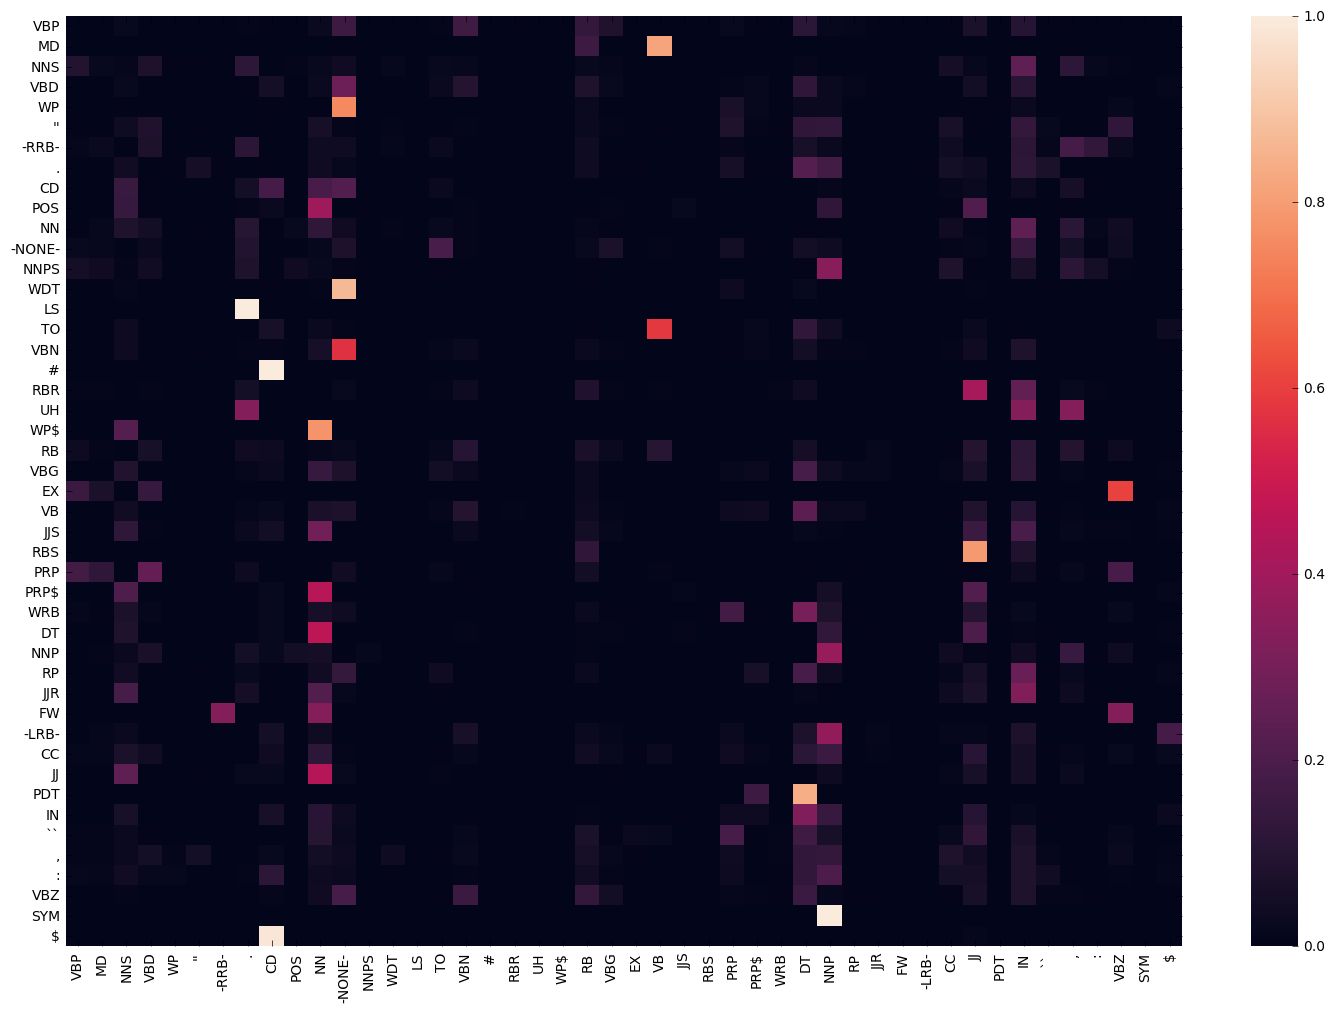

In [23]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


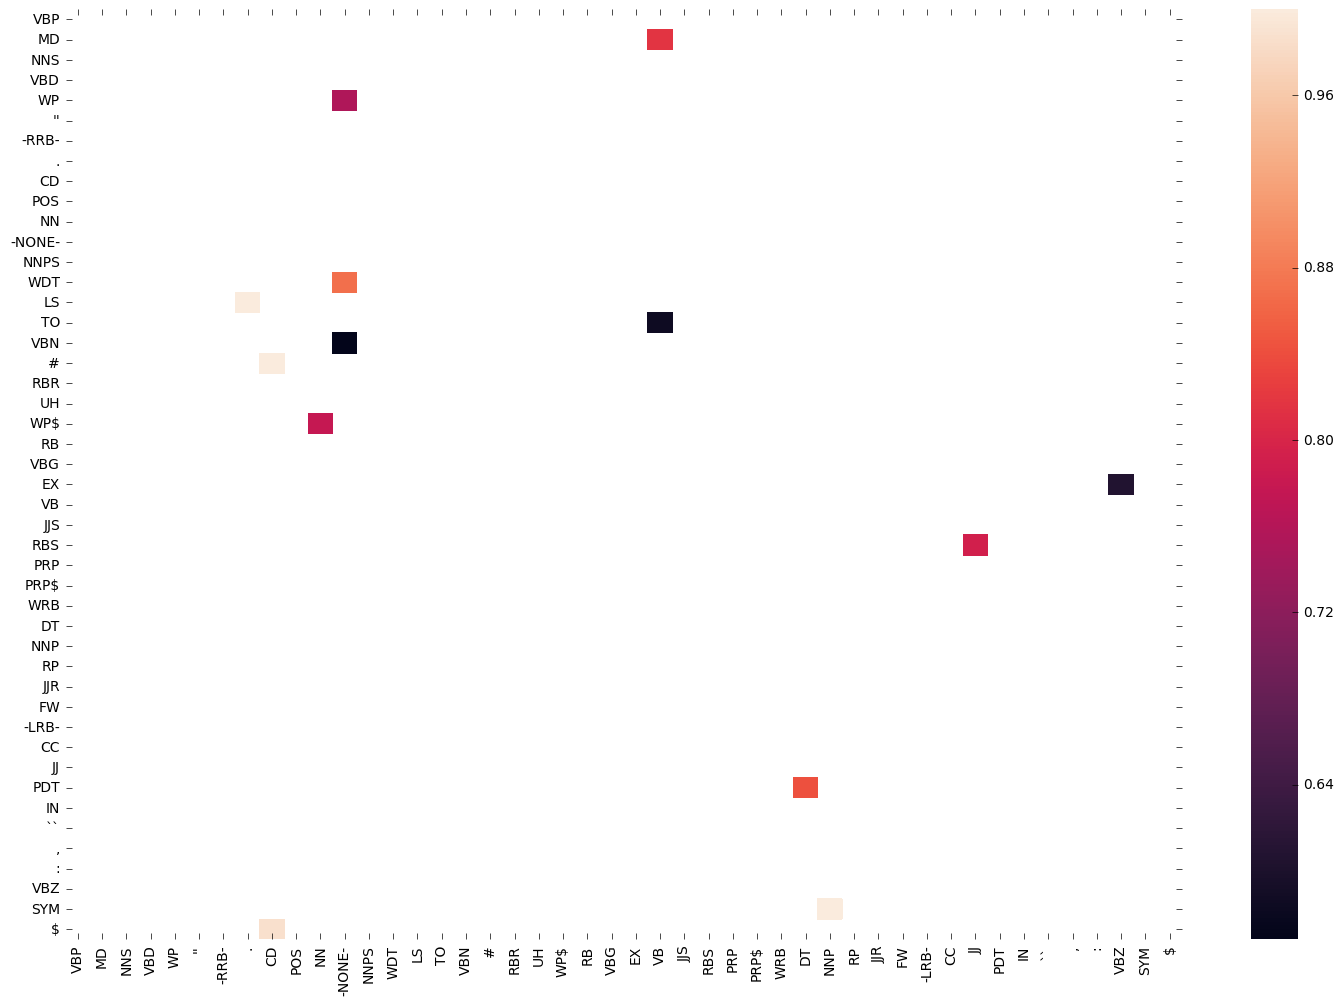

In [24]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [25]:
len(train_tagged_words)

70334

In [26]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

In [27]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('January', 'NNP'),
  ('platinum', 'NN'),
  ('was', 'VBD'),
  ('down', 'IN'),
  ('$', '$'),
  ('5.70', 'CD'),
  ('*U*', '-NONE-'),
  ('an', 'DT'),
  ('ounce', 'NN'),
  ('at', 'IN'),
  ('$', '$'),
  ('494.50', 'CD'),
  ('*U*', '-NONE-'),
  ('.', '.')],
 [('Failure', 'NN'),
  ('*', '-NONE-'),
  ('to', 'TO'),
  ('complete', 'VB'),
  ('the', 'DT'),
  ('form', 'NN'),
  ('had', 'VBD'),
  ('been', 'VBN'),
  ('punishable', 'JJ'),
  ('as', 'IN'),
  ('a', 'DT'),
  ('misdemeanor', 'NN'),
  ('until', 'IN'),
  ('last', 'JJ'),
  ('November', 'NNP'),
  (',', ','),
  ('when', 'WRB'),
  ('Congress', 'NNP'),
  ('determined', 'VBD'),
  ('that', 'IN'),
  ('the', 'DT'),
  ('crime', 'NN'),
  ('was', 'VBD'),
  ('a', 'DT'),
  ('felony', 'NN'),
  ('punishable', 'JJ'),
  ('by', 'IN'),
  ('up', 'IN'),
  ('to', 'TO'),
  ('10', 'CD'),
  ('years', 'NNS'),
  ('in', 'IN'),
  ('prison', 'NN'),
  ('*T*-1', '-NONE-'),
  ('.', '.')],
 [('The', 'DT'),
  ('loudest', 'JJS'),
  ('of', 'IN'),
  ('these', 'DT'),
  ('reformer

In [28]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [29]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  95.2592568397522
[('January', 'NNP'), ('platinum', 'NN'), ('was', 'VBD'), ('down', 'RP'), ('$', '$'), ('5.70', 'VBP'), ('*U*', '-NONE-'), ('an', 'DT'), ('ounce', 'NN'), ('at', 'IN'), ('$', '$'), ('494.50', 'VBP'), ('*U*', '-NONE-'), ('.', '.'), ('Failure', 'VBP'), ('*', '-NONE-'), ('to', 'TO'), ('complete', 'VB'), ('the', 'DT'), ('form', 'NN'), ('had', 'VBD'), ('been', 'VBN'), ('punishable', 'VBP'), ('as', 'IN'), ('a', 'DT'), ('misdemeanor', 'NN'), ('until', 'IN'), ('last', 'JJ'), ('November', 'NNP'), (',', ','), ('when', 'WRB'), ('Congress', 'NNP'), ('determined', 'VBN'), ('that', 'IN'), ('the', 'DT'), ('crime', 'NN'), ('was', 'VBD'), ('a', 'DT'), ('felony', 'NN'), ('punishable', 'VBP'), ('by', 'IN'), ('up', 'RB'), ('to', 'TO'), ('10', 'CD'), ('years', 'NNS'), ('in', 'IN'), ('prison', 'NN'), ('*T*-1', '-NONE-'), ('.', '.'), ('The', 'DT'), ('loudest', 'VBP'), ('of', 'IN'), ('these', 'DT'), ('reformers', 'VBP'), ('are', 'VBP'), ('money', 'NN'), ('managers', 'NNS'

In [30]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [31]:
accuracy = len(check)/len(tagged_seq)

In [32]:
accuracy

0.8314606741573034

In [33]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [34]:
incorrect_tagged_cases

[[('was', 'VBD'), (('down', 'RP'), ('down', 'IN'))],
 [('$', '$'), (('5.70', 'VBP'), ('5.70', 'CD'))],
 [('$', '$'), (('494.50', 'VBP'), ('494.50', 'CD'))],
 [('.', '.'), (('Failure', 'VBP'), ('Failure', 'NN'))],
 [('been', 'VBN'), (('punishable', 'VBP'), ('punishable', 'JJ'))],
 [('Congress', 'NNP'), (('determined', 'VBN'), ('determined', 'VBD'))],
 [('felony', 'NN'), (('punishable', 'VBP'), ('punishable', 'JJ'))],
 [('by', 'IN'), (('up', 'RB'), ('up', 'IN'))],
 [('The', 'DT'), (('loudest', 'VBP'), ('loudest', 'JJS'))],
 [('these', 'DT'), (('reformers', 'VBP'), ('reformers', 'NNS'))],
 [('the', 'DT'), (('busiest', 'VBP'), ('busiest', 'JJS'))],
 [('year', 'NN'), (('so', 'IN'), ('so', 'RB'))],
 [('so', 'RB'), (('far', 'RB'), ('far', 'JJ'))],
 [('volume', 'NN'), (('averaged', 'VBP'), ('averaged', 'VBD'))],
 [('roughly', 'RB'), (('145', 'VBP'), ('145', 'CD'))]]

In [35]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [36]:
print(tagged_seq)
print(difference)

[('Twitter', 'VBP'), ('is', 'VBZ'), ('the', 'DT'), ('best', 'JJS'), ('networking', 'VBP'), ('social', 'JJ'), ('site', 'VBP'), ('.', '.'), ('Man', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('social', 'JJ'), ('animal', 'VBP'), ('.', '.'), ('Data', 'NNP'), ('science', 'NN'), ('is', 'VBZ'), ('an', 'DT'), ('emerging', 'VBG'), ('field', 'NN'), ('.', '.'), ('Data', 'NNP'), ('science', 'NN'), ('jobs', 'NNS'), ('are', 'VBP'), ('high', 'JJ'), ('in', 'IN'), ('demand', 'NN'), ('.', '.')]
31.70490527153015
